In [1]:
from pathlib import Path
from dotenv import dotenv_values
import os

# ROOT
HERE = Path('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my/src')#(os.path.dirname(os.path.abspath(__file__)))
config = dotenv_values(HERE / "root.env")
ROOT = Path(config['ROOT'])
ROOT

PosixPath('/Users/ihor/Documents/Py/Yay/OCR/doc2graph_my')

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
%load_ext autoreload
%autoreload 2

In [60]:
from src.data.download import funsd

#! uncomment this to download.
# funsd() 

In [4]:
def file_to_images(file, gray=False):
    import fitz

    if file[-3:].lower() == 'pdf':
        imgs = []
        
        zoom = 3    # zoom factor
        mat = fitz.Matrix(zoom, zoom)
        
        with fitz.open(file) as pdf:
            for pno in range(pdf.page_count):
                page = pdf.load_page(pno)
                pix = page.get_pixmap(matrix=mat)
                # if width or height > 2000 pixels, don't enlarge the image
                #if pix.width > 2000 or pix.height > 2000:
                #    pix = page.get_pixmap(matrix=fitz.Matrix(1, 1)
                
                mode = "RGBA" if pix.alpha else "RGB"                        
                img = Image.frombytes(mode, [pix.width, pix.height], pix.samples)                        
                
                if gray:
                    img = img.convert('L')
                else:
                    img = img.convert('RGB')
                    
                imgs.append(img)
    else:
        if gray:
            img = Image.open(file).convert('L')
        else:
            img = Image.open(file).convert('RGB')
            
        imgs=[img]

    return imgs

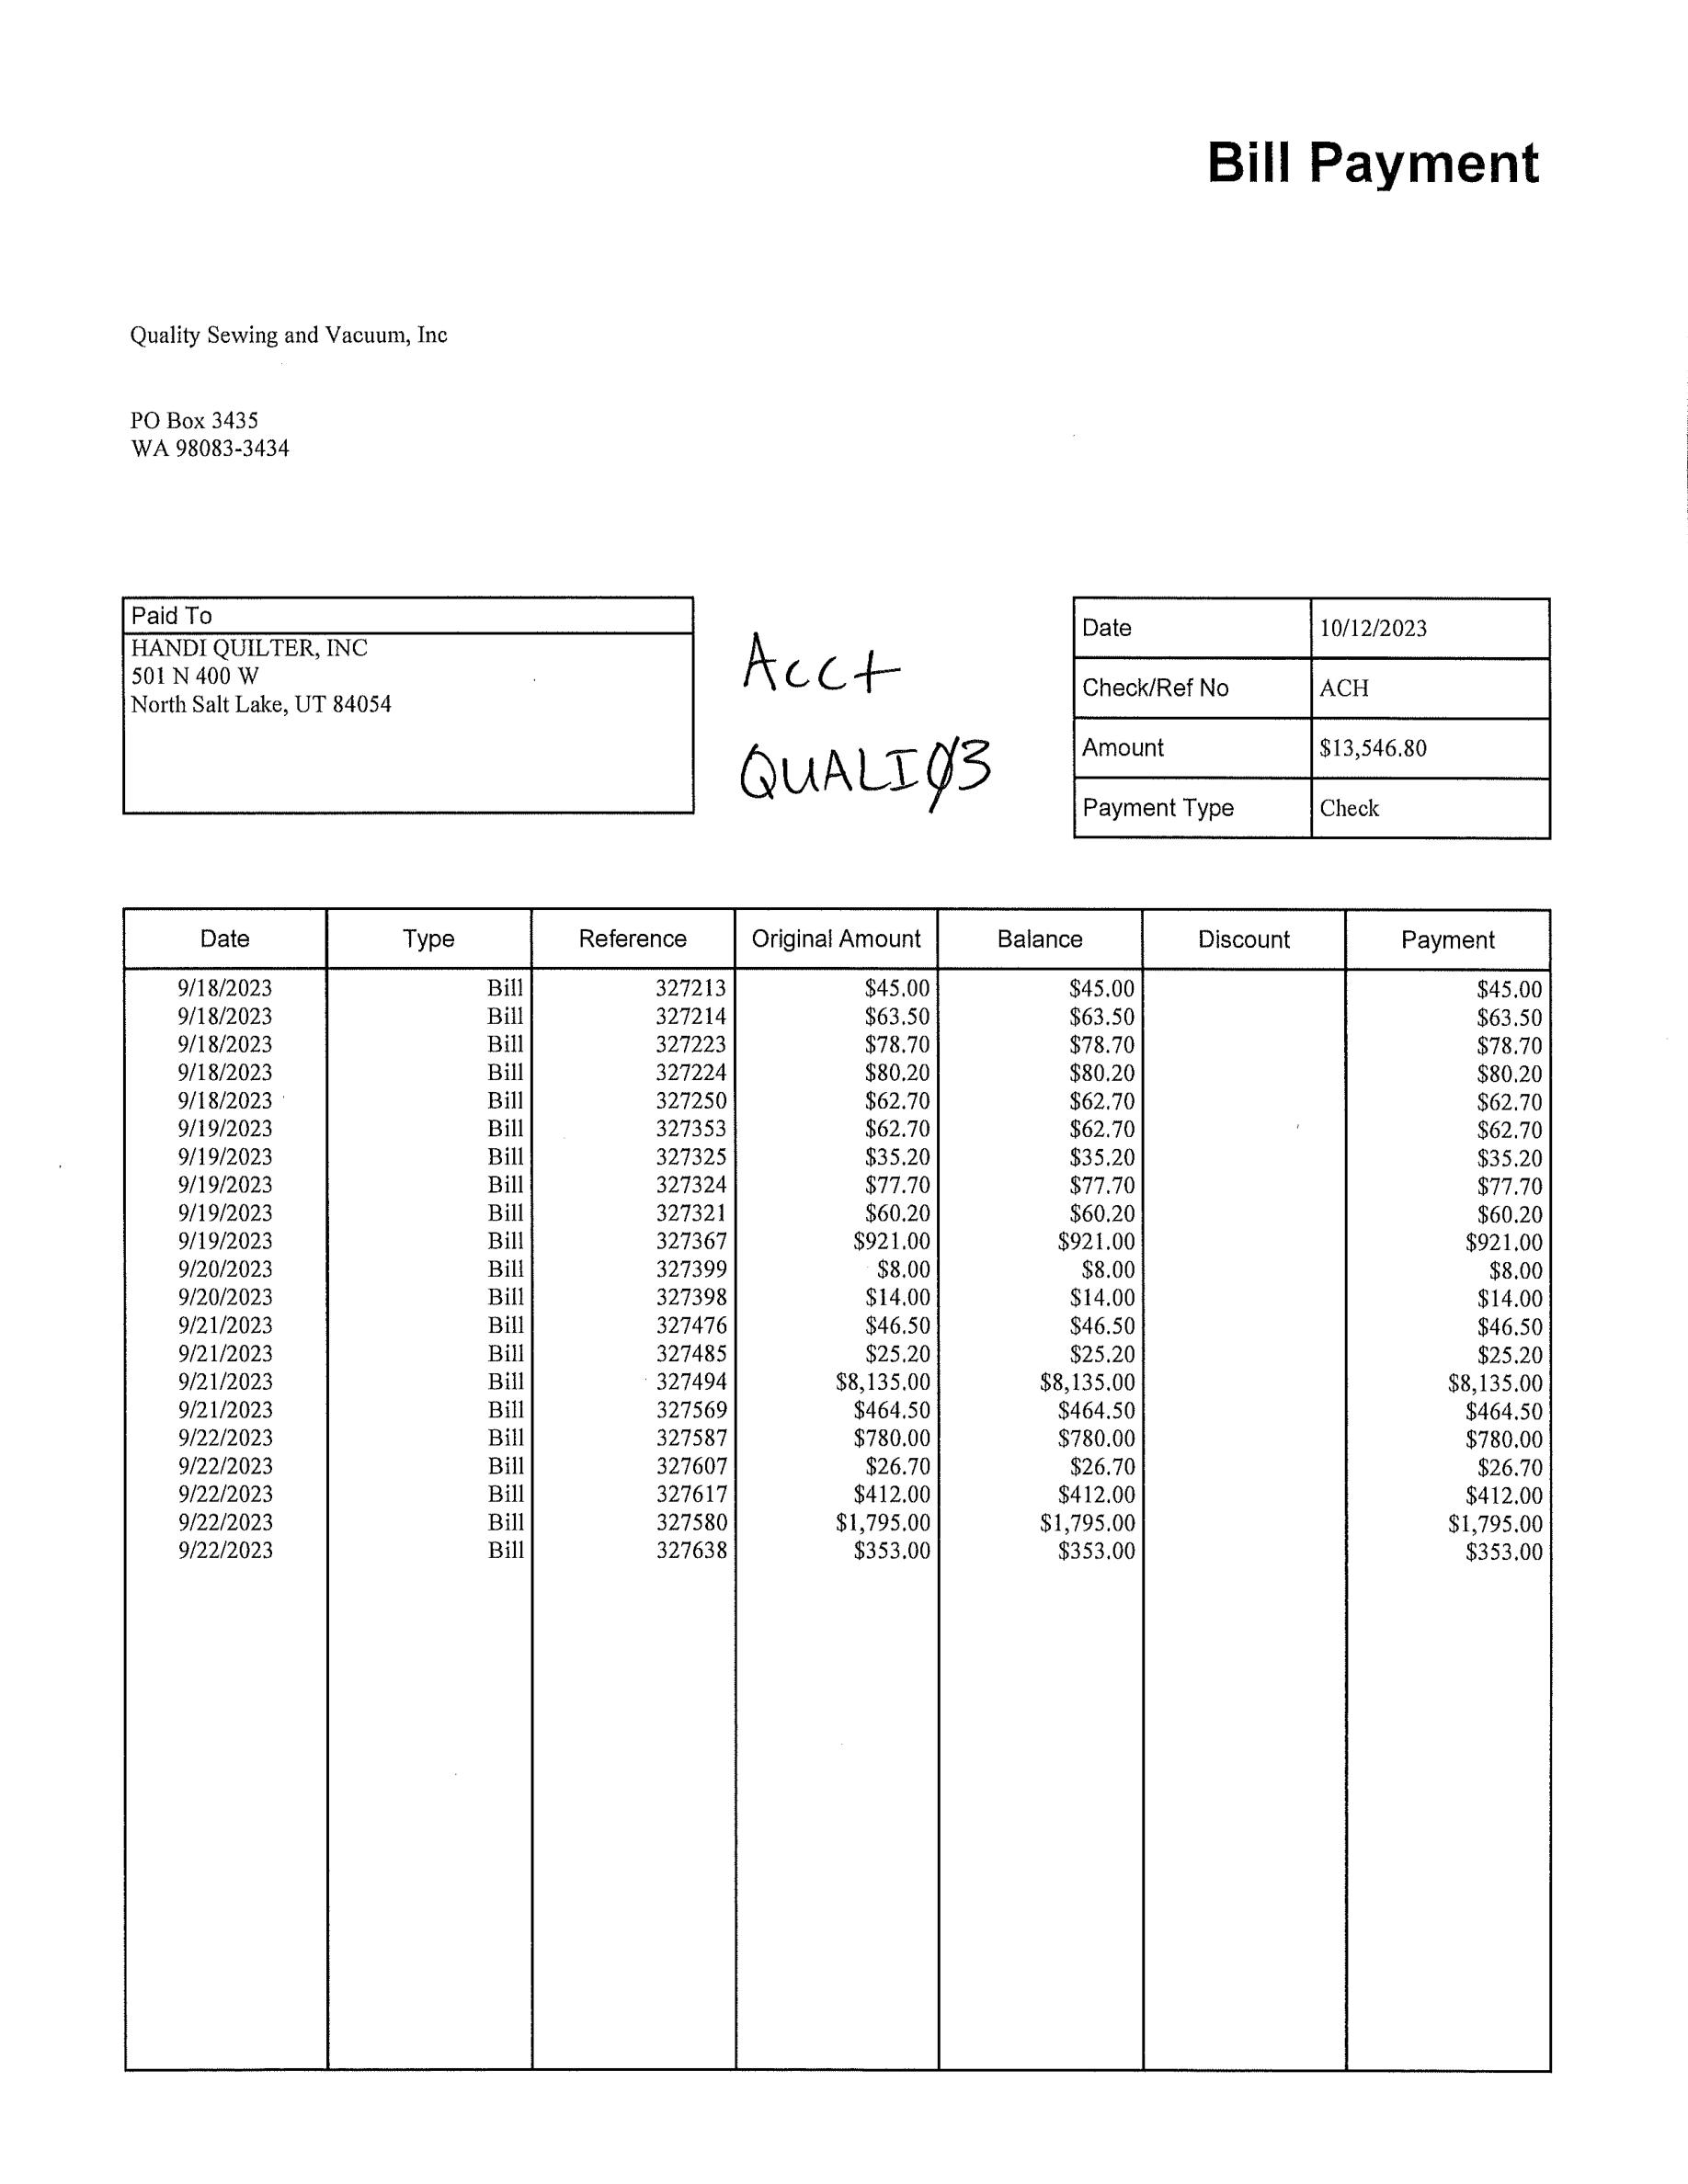

In [233]:
from src.paths import FUNSD_TEST, DATA ,CHECKPOINTS, REMITTANCE_VAL
from PIL import Image, ImageDraw, ImageFont


#funsd_test_images = FUNSD_TEST / 'images'
image_name = '3db20986-b966-486a-b4c7-7f88ffc92f10.jpg' #! change this to see different outputs from FUNSD, or pass your own image!

#funsd_test_images = REMITTANCE_VAL / 'images' 
#image_name = '00c325a1-6fe2-43c6-a8de-d01ba451ef91.jpg'
image_path = str(DATA / image_name)
image = Image.open(image_path).convert('RGB')
#image = file_to_images(image_path)[0]
#image.save(image_path.split('.')[0]+'.jpg')
image

In [ ]:
import easyocr

from src.data.preprocessing import center

reader = easyocr.Reader(['en']) #! support multilingual!

def apply_ocr(path):
    result = reader.readtext(path, 
                             min_size=10, 
                            slope_ths=0.2, 
                            ycenter_ths=0.5, 
                            height_ths=0.5, 
                            width_ths=0.5,
                            decoder='wordbeamsearch', 
                            beamWidth=10, )
    boxs, texts = list(), list()

    # transform the OCR result in a handle format
    for r in result:
        box = [int(r[0][0][0]), int(r[0][0][1]), int(r[0][2][0]), int(r[0][2][1])]
        boxs.append(box)
        texts.append(r[1])
    
    return boxs, texts


In [97]:
def draw_results(img, boxs, links, labels):
    draw = ImageDraw.Draw(img)

    for box in boxs:
        draw.rectangle(box, outline='blue', width=3)
    
    if links:
        for idx in range(len(links['src'])):
            key_center = center(boxs[links['src'][idx]])
            value_center = center(boxs[links['dst'][idx]])
            draw.ellipse((tuple(x-4 for x in key_center) + tuple(x+4 for x in key_center)), fill = 'red')
            draw.ellipse((tuple(x-4 for x in value_center) + tuple(x+4 for x in value_center)), fill = 'red')
            draw.line((key_center, value_center), fill='violet', width=3)
            

In [26]:
def get_word_boxes(image_path):
    import io
    import requests
    import base64
    import json

    pil_image = file_to_images(image_path)[0]
    with io.BytesIO() as buffer:
        pil_image.save(buffer, format='jpeg')
        image_bytes = buffer.getvalue()
        
    data = {
        "image_bytes":base64.b64encode(image_bytes).decode("utf8")
    }

    host = 'https://xiqo6syt8a.execute-api.us-east-1.amazonaws.com/paddleocr_textboxes/calc_embedding'
    response = requests.post(f"{host}",
                    data=json.dumps(data),
                    headers={'content-type':'application/json',
                            'x-amzn-RequestId': '84cad557-a68f-45db-9c01-79449f0aeecb'},#image/jpg
                    timeout=29
                    )
    
    ict_str = response.content.decode("UTF-8")
    res = json.loads(ict_str)
    
    return res

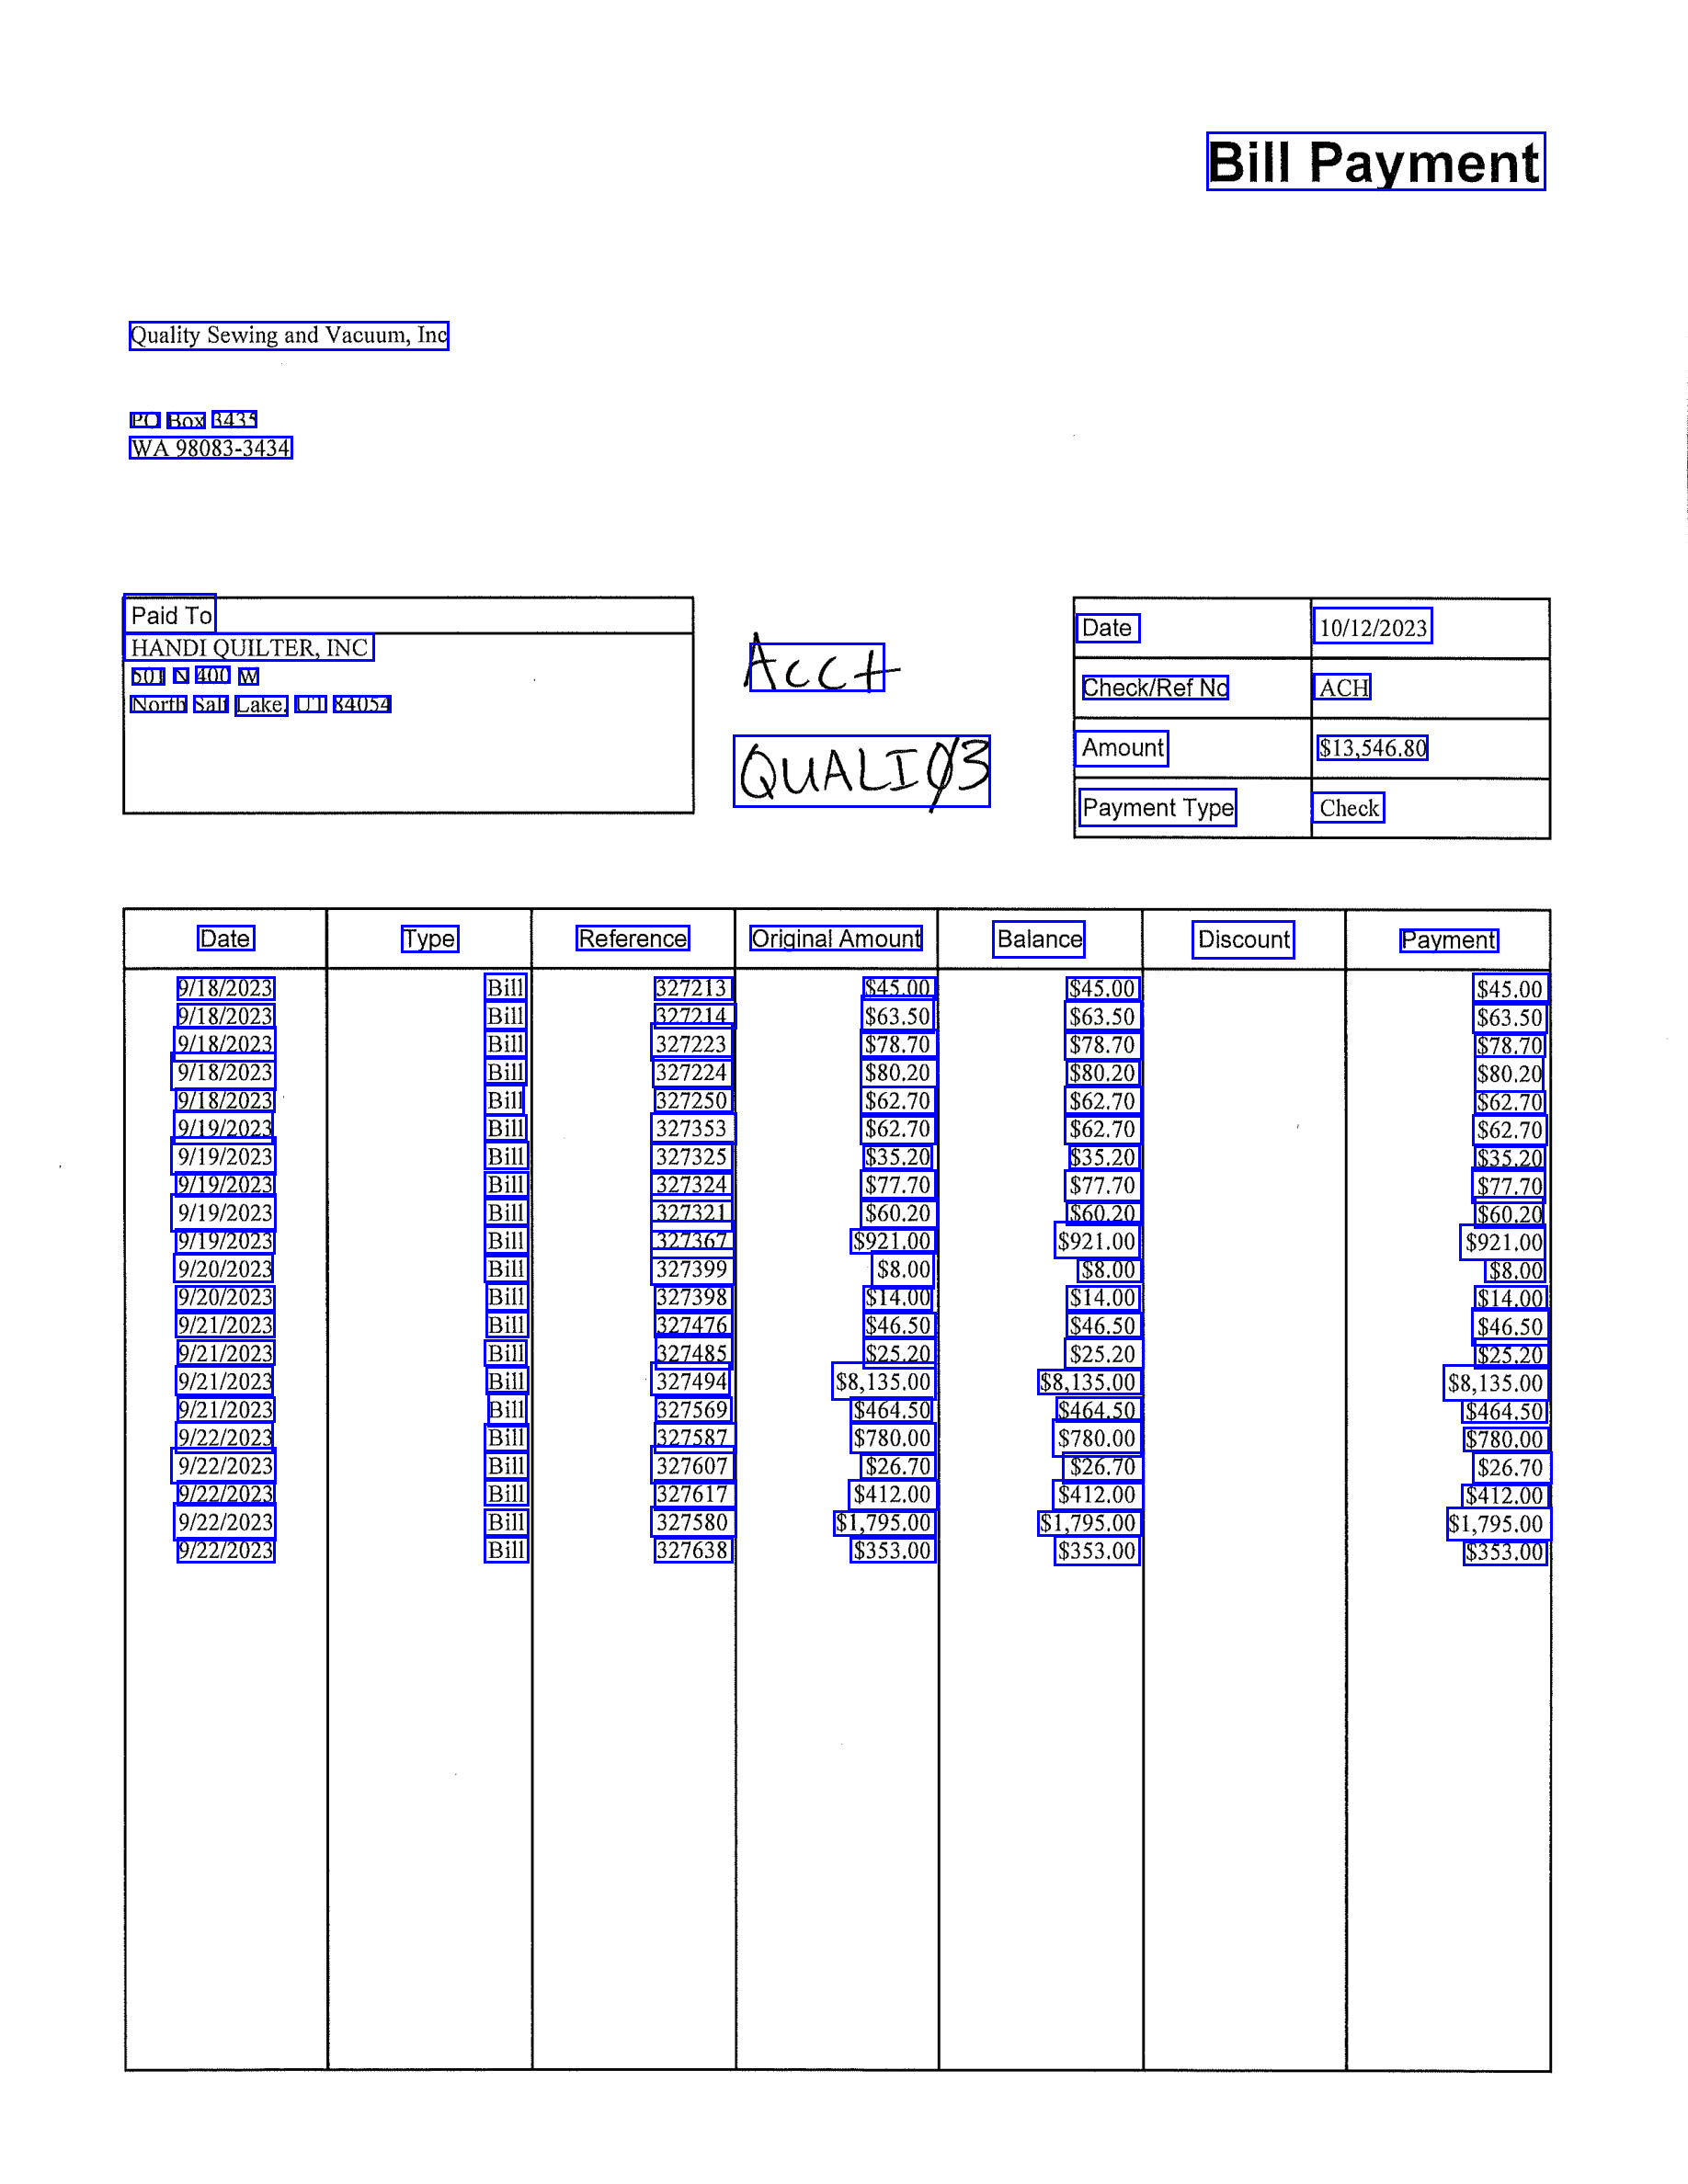

In [234]:
#! get text boxes and contents
#boxes, texts = apply_ocr(image_path)
word_boxes = get_word_boxes(image_path)
boxes = word_boxes['boxes']
texts = word_boxes['words']
size = image.size
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]

r_im = image.copy()
draw_results(r_im, boxes, None, [])
r_im

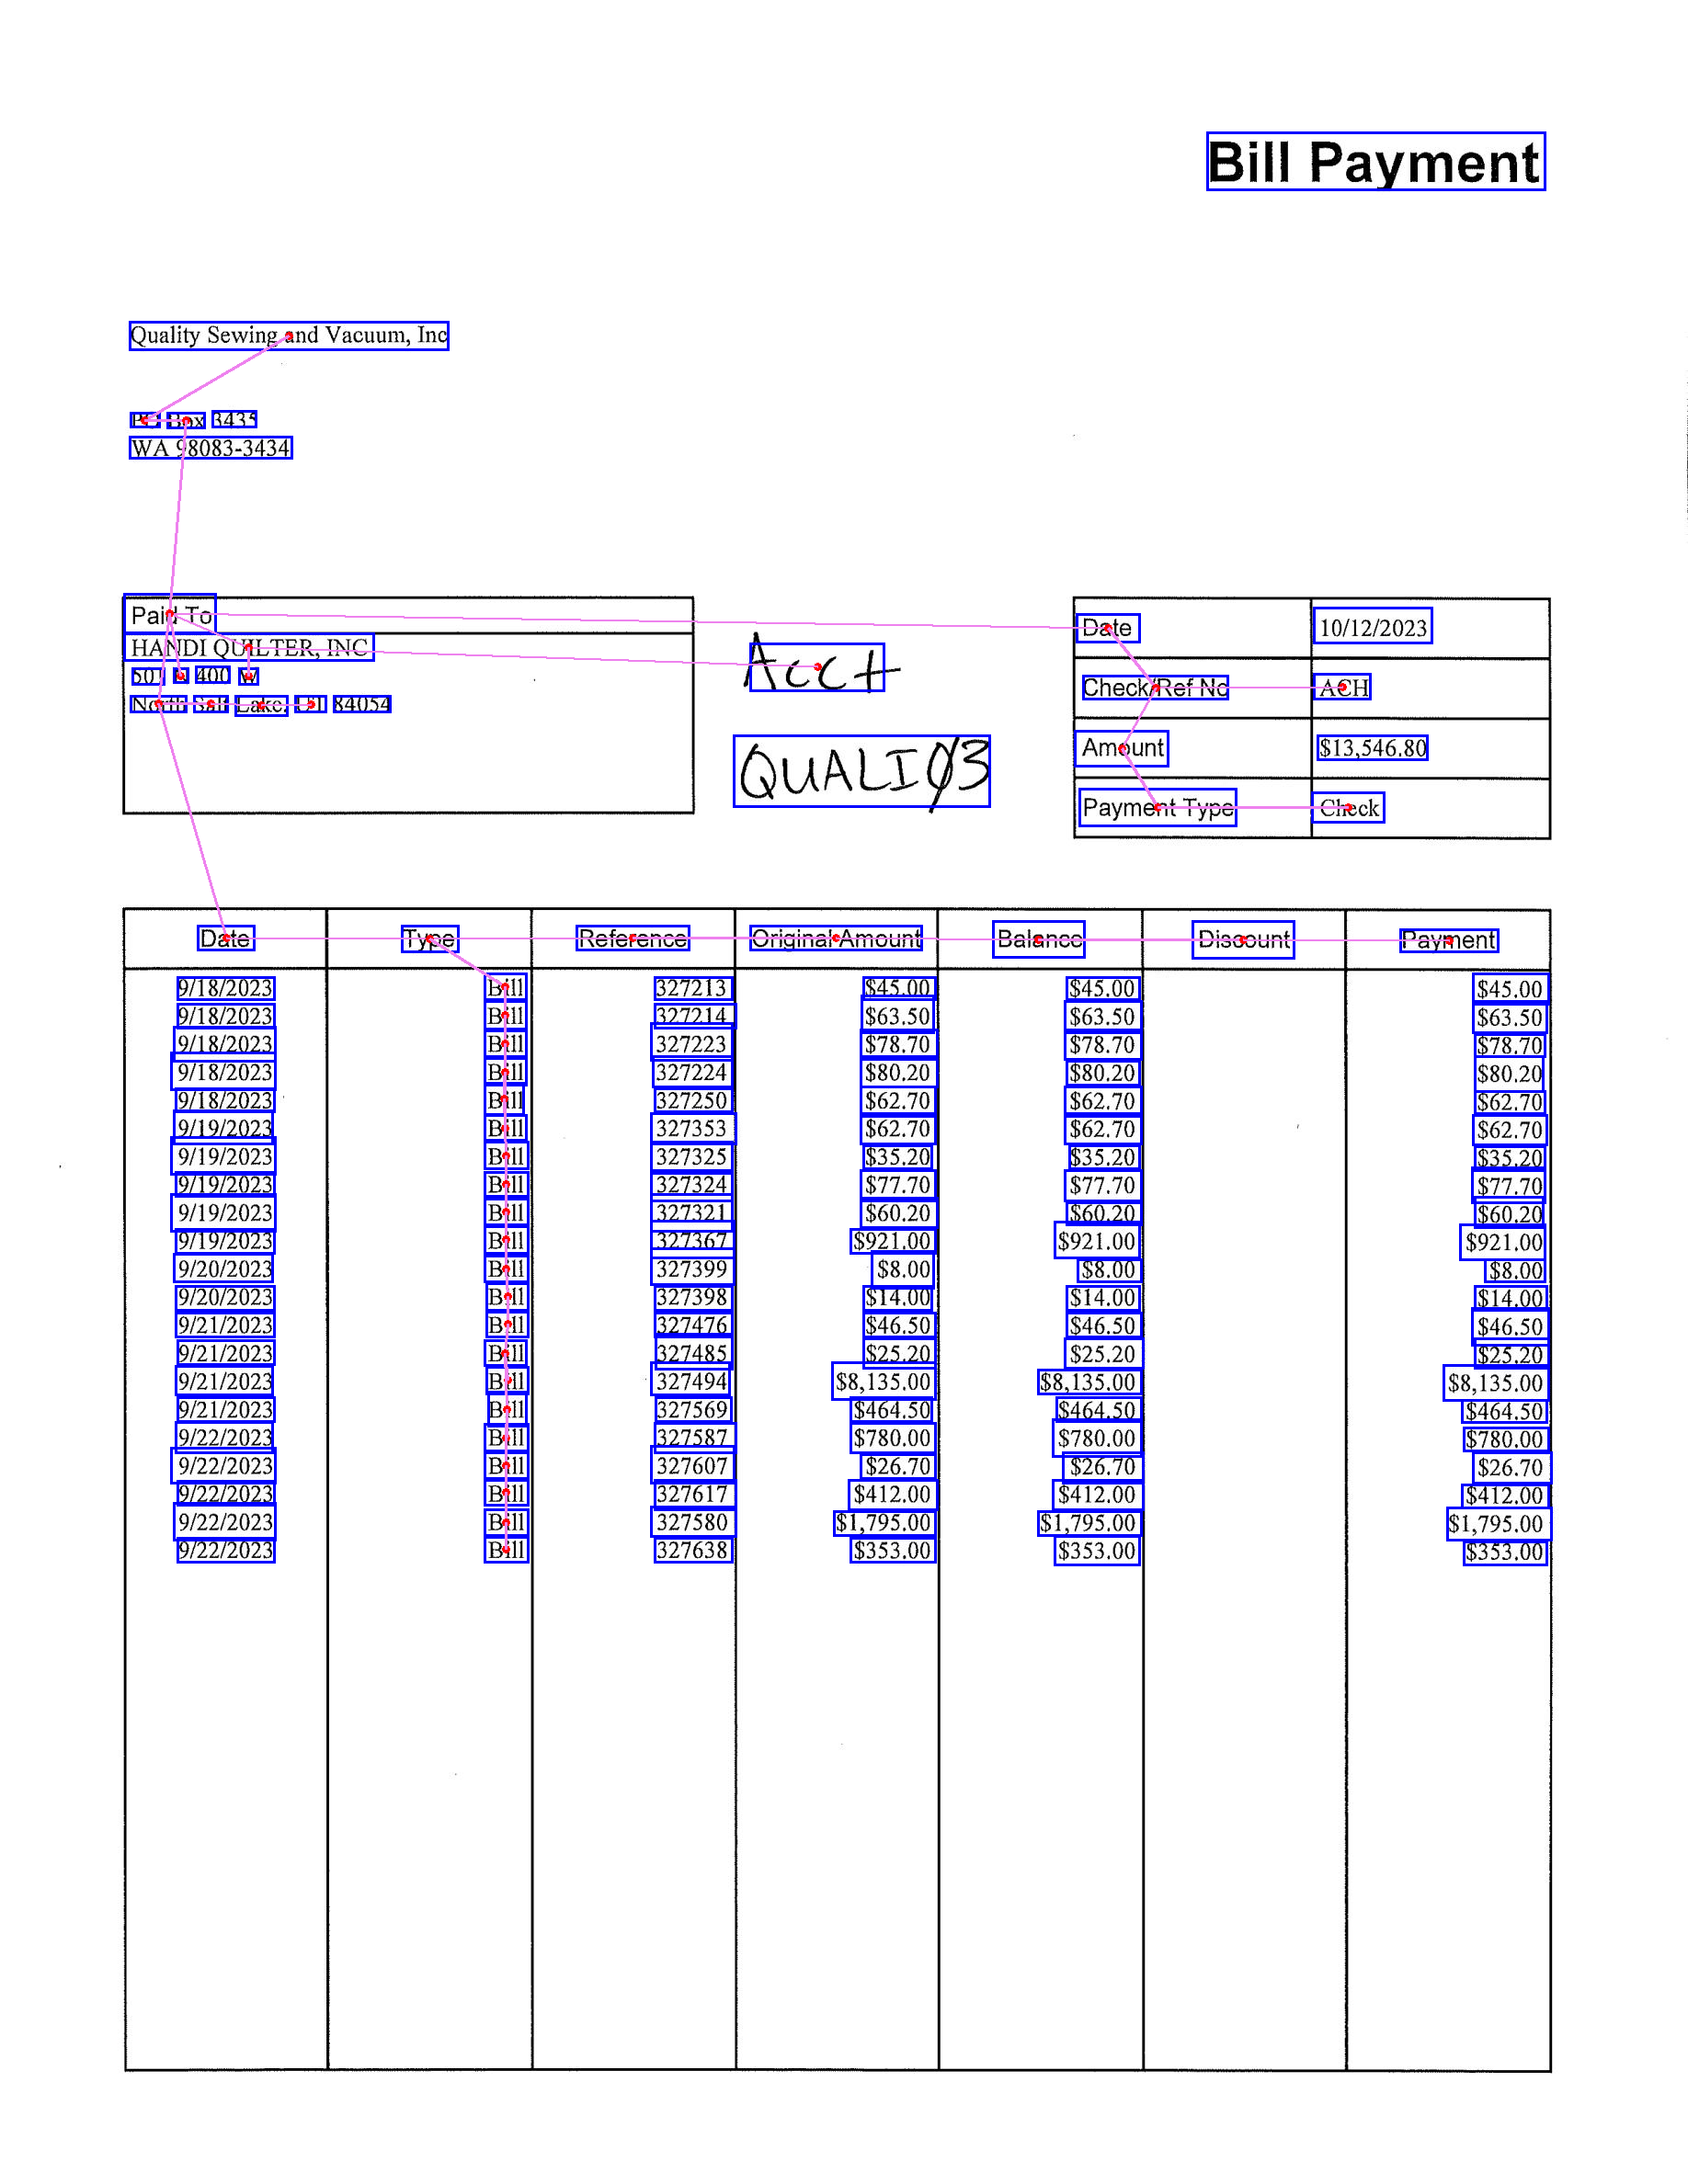

In [286]:
from src.data.graph_builder import GraphBuilder

k = 4 #! try changing this value!

gb = GraphBuilder()
u, v = gb.half_fully_connected2(boxes, texts, 1, 'word_to_word')
links = {'src': u, 'dst': v}
im_c = image.copy()
draw_results(im_c, boxes, links, None)
im_c

In [236]:
gb = GraphBuilder()
graphs, node_labels, edge_labels, features = gb.get_graph([image_path], 'CUSTOM')
graph = graphs[0] # we have only one for this tutorial!
graph

Graph(num_nodes=160, num_edges=45,
      ndata_schemes={}
      edata_schemes={})

In [123]:
from src.data.feature_builder import FeatureBuilder

device = 'cpu'#'cuda:0' # change this to 'cpu' in case you cannot use hardware acceleration
fb = FeatureBuilder(d=device)
fb.get_info()

-> textual feats: True
-> text masked: False
-> visual feats: False
-> geom feats: False
-> size feats: False
-> edge epolar: False
-> edge edist: False


In [237]:
chunks, _ = fb.add_features(graphs, features) # chunks is used by the model to merge different embeddings together!
graphs, chunks

adding features: 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


([Graph(num_nodes=160, num_edges=45,
        ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(384,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32)}
        edata_schemes={'feat': Scheme(shape=(0,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32)})],
 [384])

In [238]:
graph.ndata['feat'].shape,graph.ndata['geom'].shape, graph.edata['feat'].shape

(torch.Size([160, 384]), torch.Size([160, 4]), torch.Size([45, 0]))

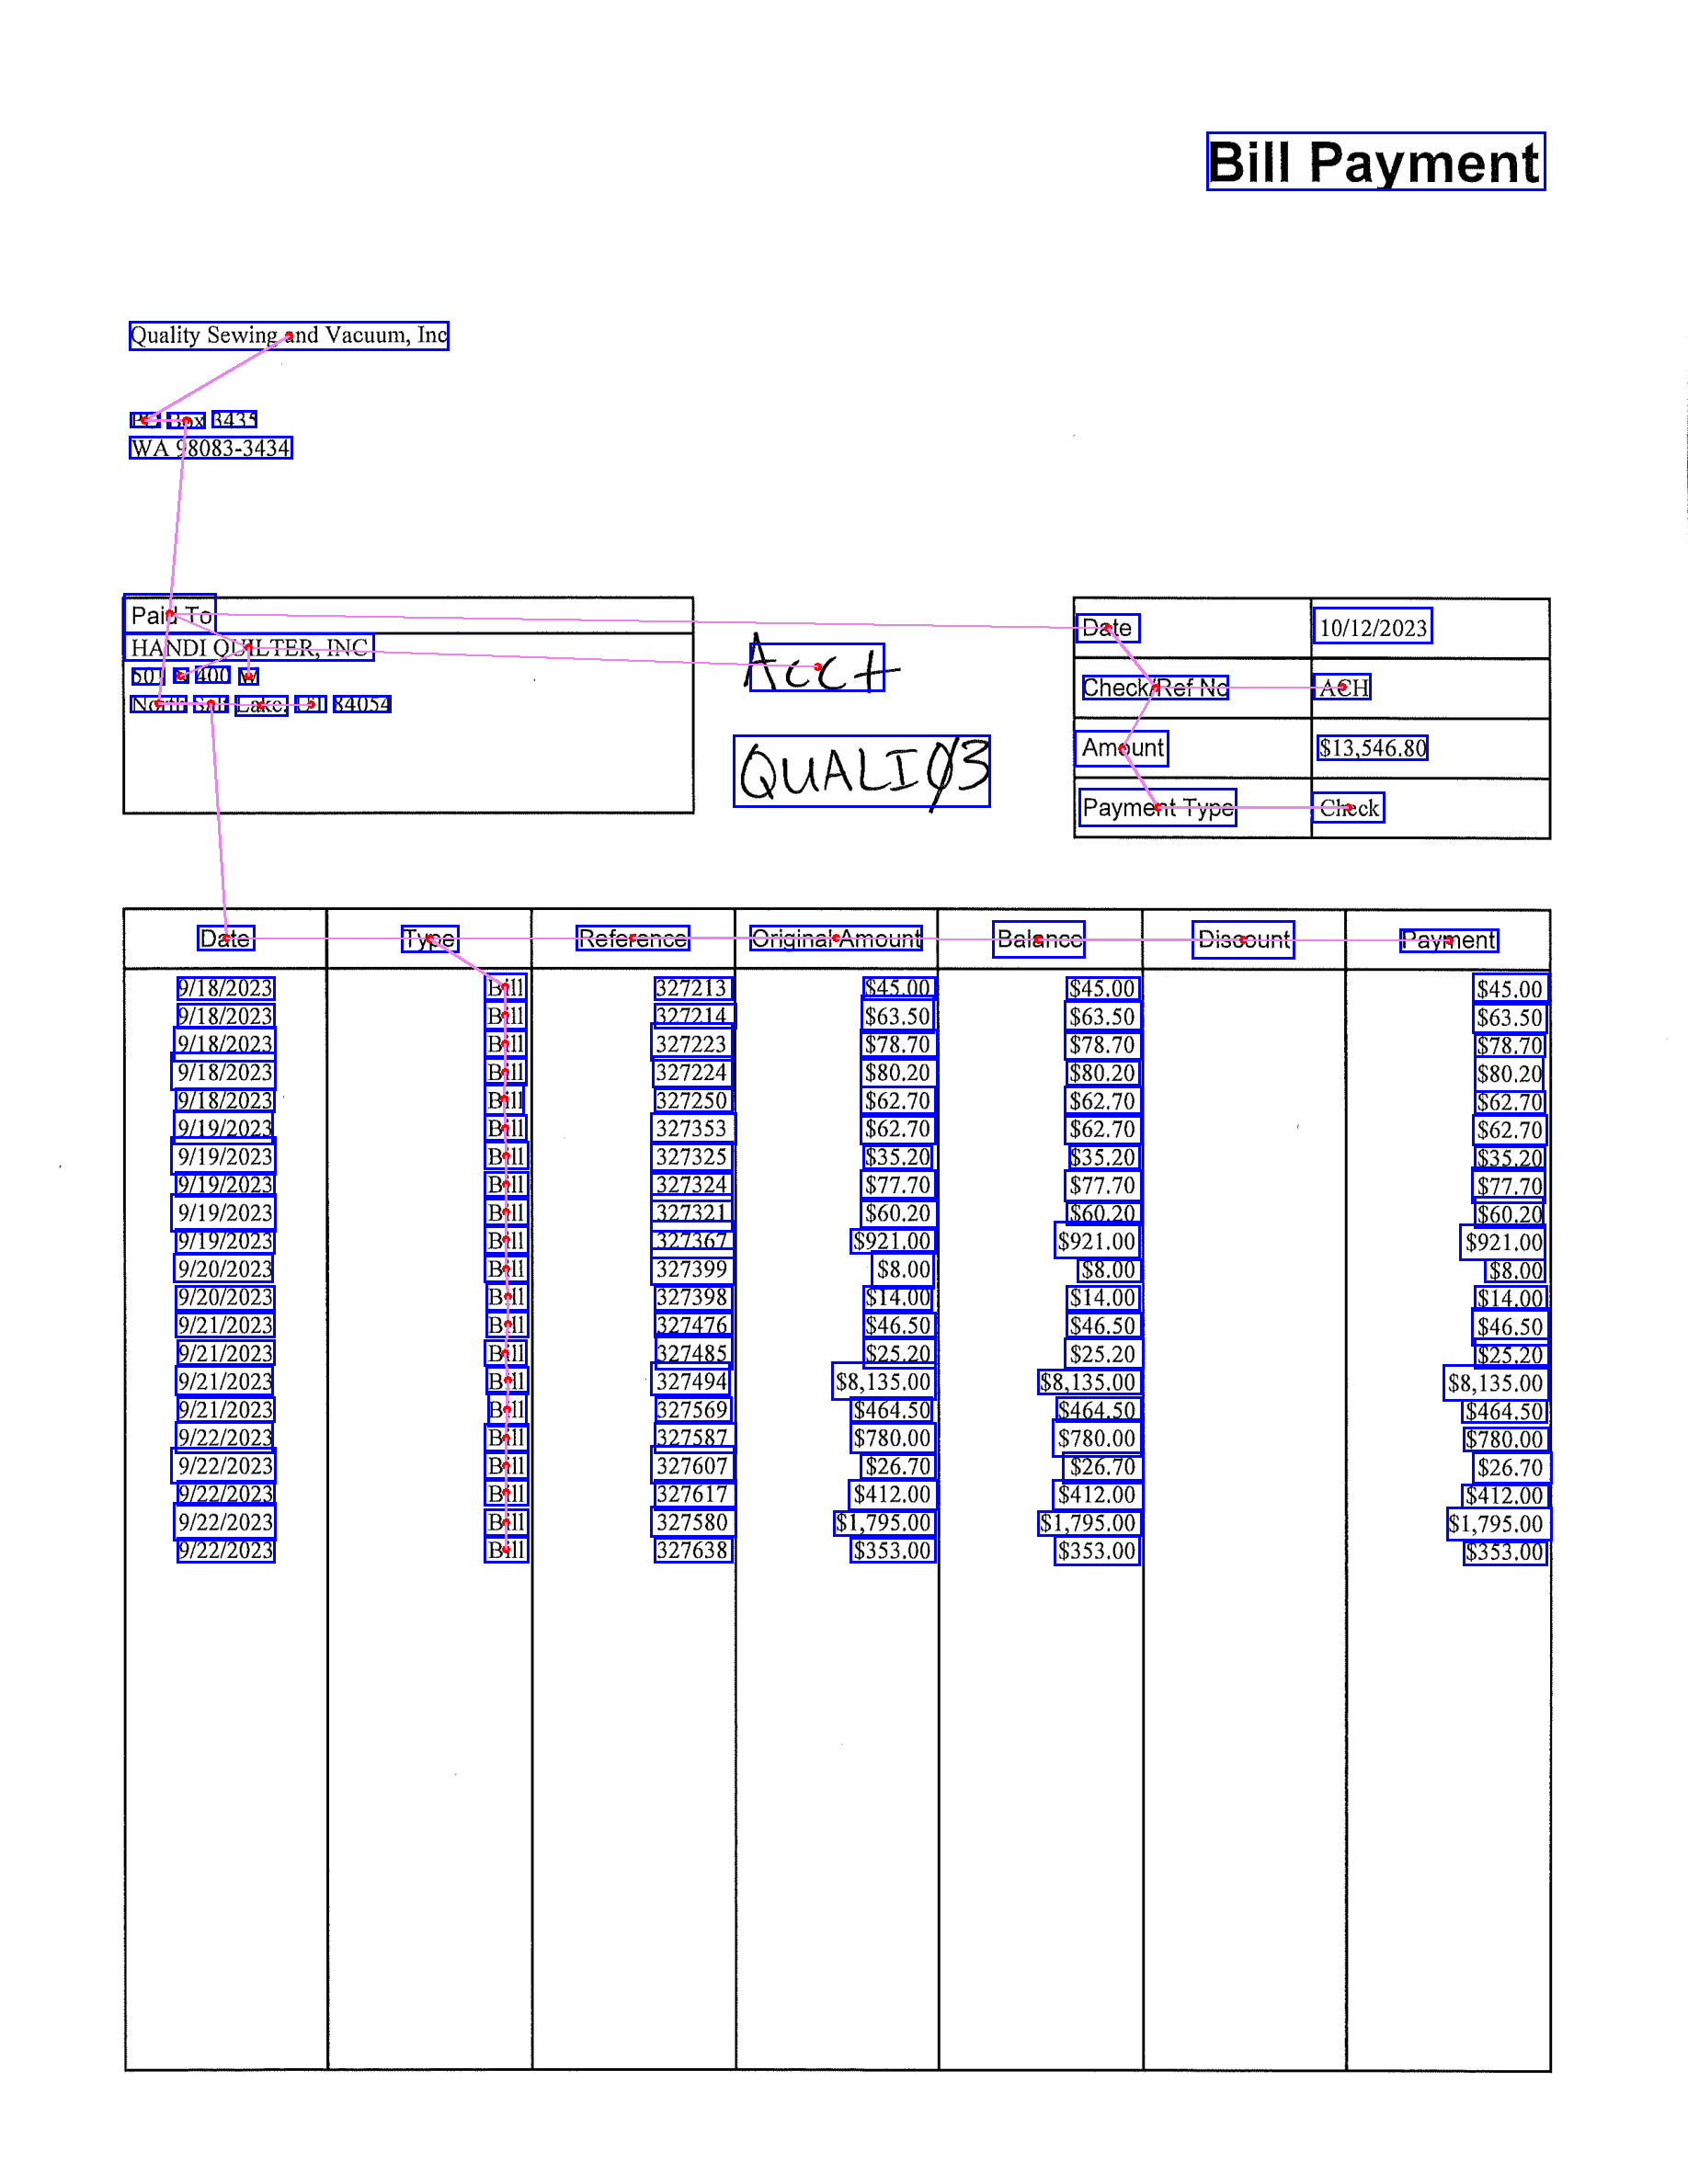

In [239]:
u,v = graph.edges()
links = {'src': u, 'dst': v}
image_path = features['paths'][0]
image = Image.open(image_path).convert('RGB')
im_c = image.copy()
draw_results(im_c, features['boxs'][0], links, None)
im_c

In [240]:
from torch_geometric.data import Data

geometric_graph = Data(x=graph.ndata['feat'], 
                    edge_index= torch.stack(graph.edges(), dim=0).to(torch.int64), 
                    edge_attr= graph.edata['feat'])
x, edge_index, edge_attr = geometric_graph.x, geometric_graph.edge_index, geometric_graph.edge_attr

In [241]:
x.shape, edge_index.shape

(torch.Size([160, 384]), torch.Size([2, 45]))

In [282]:
from src.models.utils import GCNConvM, SAGEConvM, InputProjectorSimple, GATConvM, GATv2ConvM
conv = GATv2ConvM(384, 384, edge_dim = 2, heads=1, dropout = 0, v2 = False, add_self_loops = False, aggr='add', bias=False)
x_new = conv(x, edge_index)

In [243]:
#x_source = x_new

In [244]:
features.keys()

dict_keys(['paths', 'texts', 'boxs'])

In [270]:
from torchmetrics.functional.pairwise import pairwise_cosine_similarity, pairwise_euclidean_distance
pd = pairwise_euclidean_distance(x_source, x_new)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchmetrics/functional/pairwise/euclidean.py:33: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3575.)
  y_norm = y.norm(dim=1).T


In [285]:
geom = features['boxs'][0]
text = features['texts'][0]
for i in range(len(geom)):
    #print(i)
    if text[i]=='Discount':
        print(text[i])
        print(list(x[i].detach().numpy()))
        print(list(x_new[i].detach().numpy()))
        break

Discount
[0.14615832, 0.21250561, -0.03589232, -0.041714564, -0.010213431, -0.108709425, 0.40840232, 0.10431031, -0.056118466, -0.015518419, 0.100195676, -0.14460915, 0.18998003, -0.044534657, -0.09730233, 0.029370118, -0.05145413, 0.1244716, -0.052185014, 0.03704206, 0.16863608, -0.016927285, -0.08755477, -0.027057022, -0.05232848, 0.025881141, -0.1534569, -0.13007961, -0.033508208, -0.41192508, 0.07752385, -0.09378687, 0.05367876, 0.18833894, 0.069821395, 0.12186527, -0.05143438, 0.12803346, 0.1318819, 0.012434435, -0.048485246, 0.15177202, -0.0042236783, 0.13613805, 0.08104652, 0.07422943, -0.019111726, 0.09305613, -0.060051277, 0.059746448, 0.10861202, 0.07165572, -0.17450397, -0.06240463, 0.16923332, 0.13685502, 0.15320462, 0.08768398, -0.14718561, 0.18877244, -0.019725863, 0.05432383, -0.87949187, 0.1801348, -0.14082442, -0.022548255, 0.033374555, -0.0056591164, -0.086934924, 0.38847196, 0.051228203, -0.02982838, -0.06781387, 0.06181743, 0.10362529, 0.0054680463, -0.016268779, 0.

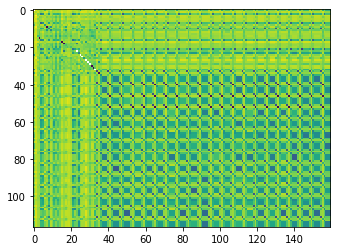

In [271]:
import matplotlib.pyplot as plt
plt.imshow(pd.detach().numpy(), interpolation='none')

In [277]:
import numpy as np
np.argmin(pd[17,:].detach().numpy())

15

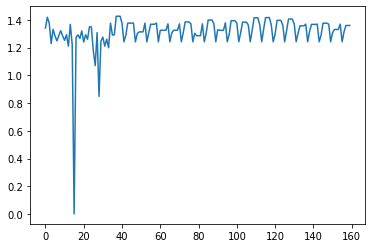

In [275]:
plt.plot(pd[17,:].detach().numpy())

# Model

In [143]:
import torch
from src.models.graphs import SetModel
from src.paths import CHECKPOINTS

device = 'cpu'
sm = SetModel(name='gat', device=device)
model = sm.get_model(7, 4, [300], False) # 4 and 2 refers to nodes and edge classes, check paper for details!
#model.load_state_dict(torch.load(CHECKPOINTS / 'gat-20230807-1428.pt', map_location=torch.device('cpu'))) # load pretrained model
model.eval()


### MODEL ###
-> Using GAT
-> Total params: 286291
-> Device: False



GAT(
  (drop): Dropout(p=0, inplace=False)
  (message_passing): GATv2ConvM(300, 300, heads=1)
  (node_pred): InputProjectorSimple(
    (node_pred): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=256, out_features=7, bias=True)
    )
  )
)

In [144]:
sm.cfg_model

AttrDict({'name': 'GAT', 'dropout': 0, 'n_heads': 1, 'node_projector_dim': 128, 'edge_projector_dim': 128, 'num_layers': 1, 'doProject': False, 'doNorm': False})

In [656]:

# from src.data.dataloader import Document2Graph
# from src.paths import TEST_SAMPLES, INF, REMITTANCE_TEST

# test_data = Document2Graph(name='REMITTANCE TEST', src_path=INF, device = device, output_dir=TEST_SAMPLES)
# test_data.get_info()

In [14]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

In [265]:
from torch_geometric.data import Data
pygraph = Data()
dgl_graph = graphs[0]
        
geometric_graph = Data(x=dgl_graph.ndata['feat'], 
                        edge_index= torch.stack(dgl_graph.edges(), dim=0).to(torch.int64), 
                        edge_attr= dgl_graph.edata['feat'])

geometric_graph = geometric_graph.to(device)
geometric_graph['geom'] = dgl_graph.ndata['geom']

In [266]:
node_unique_labels =['O', 'invoice_amount', 'invoice_date', 'invoice_number', 'payment_amount', 'payment_date', 'payment_number']

In [270]:
from torch.nn import functional as F
import numpy as np
from src.training.utils import *

ind=1
#graph = test_data.graphs[ind]
#inference = Image.open(test_data.paths[ind]).convert('RGB')
graph = graphs[0]
inference = image.copy()
size = inference.size

boxes = list(graph.ndata['geom'].numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]

with torch.no_grad():
    n = model(geometric_graph.to(device))
    score, npreds = torch.max(F.softmax(n, dim=1), dim=1)
    
    arr = npreds.numpy()
    li = list(np.where(arr>0)[0]) 
    
    labels = [node_unique_labels[arr[i]]+f'%6.2f' %score[i] for i in li]
    score = [f'%6.2f' % score[i] for i in li]

    # save results
    links = (epreds == 1).nonzero(as_tuple=True)[0].tolist()
    
    entities = [boxes[i] for i in li]

    inference = draw_boxes(inference, entities, labels)
    
inference

NameError: name 'model' is not defined

# Test

In [185]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 2],
                           [1, 1, 1]], dtype=torch.long)
x = torch.tensor([[1], [1], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

In [717]:
from src.main import seed_everything
from src.models.utils import GATConvM

import os
import random
import numpy as np
import torch
import pytorch_lightning as pl


seed = 42
#random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

edge_index = torch.tensor([[1, 2, 3,1,2], [0, 0, 0,1,2]], dtype=torch.long)  # 2 x E
edge_attr = torch.tensor([[1,2], [1,2], [1,2], [1,2],[1,2]], dtype=torch.float)
x = torch.tensor([[1,1], [2,2], [3,3], [4,4]], dtype=torch.float)  # N x emb(in)
x, edge_index

conv1 = GATConvM(2, 2, add_self_loops = False,  bias = False, edge_dim = 2)
conv1(x, edge_index, edge_attr)

tensor([[0.0657, 1.1494, 0.2504, 4.3802],
        [0.1314, 2.2987, 0.1314, 2.2987],
        [0.1971, 3.4481, 0.1971, 3.4481],
        [0.2628, 4.5974, 0.0000, 0.0000]], grad_fn=<ViewBackward0>)

In [750]:
from src.data.dataloader import Document2Graph
from src.paths import *

In [865]:
#test_data = Document2Graph(name='REMITTANCE TEST', src_path=REMITTANCE_TEST, device = device, output_dir=TEST_SAMPLES)
#test_data.get_info()
inf_data = Document2Graph(name='REMITTANCE INFERENCE', src_path=REMITTANCE_INFERENCE, device = device, output_dir=INFERENCE_SAMPLES)
inf_data.get_info()
test_data = inf_data

adding features: 100%|██████████| 10/10 [00:00<00:00, 65.59it/s]


REMITTANCE INFERENCE dataset:
-> graphs: 10
-> node labels: ['O' 'payment_amount']
-> edge labels: ['none']
-> node features: 6
-> edge type: fully
-> textual feats: False
                 -> visual feats: False
                 -> geom feats: False
                 -> size feats: False
                 -> edge epolar: False
                 -> edge edist: True
-> graph example: Graph(num_nodes=43, num_edges=18,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(6,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [866]:
idx=1
data = test_data[idx]

In [922]:
x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

In [925]:
from src.models.utils import GCNConvM, SAGEConvM, InputProjectorSimple, GATConvM, GATv2ConvM
conv = GATv2ConvM(6, 6, edge_dim = 2, heads=1, dropout = 0, v2 = True, add_self_loops = False, aggr='add', bias=False)
x_new = conv(x, edge_index)

In [910]:
geom = data['geom']
text = data['text']
for i in range(geom.shape[0]):
    print(list(x_new[i].detach().numpy()), text[i], data.y[i].numpy() ) #list(geom[i].numpy()), list(data.x[i].numpy()),'->',

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] P.O 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Box 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 248 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Vendor 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ACP 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Green 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Bay, 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] WI 0
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0] 54305 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (920) 435-5353 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Fax (920) 438-0389 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] Payment 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] cccp.com 0
[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] CreativIT 0
[0.0, 0.0, 0.0

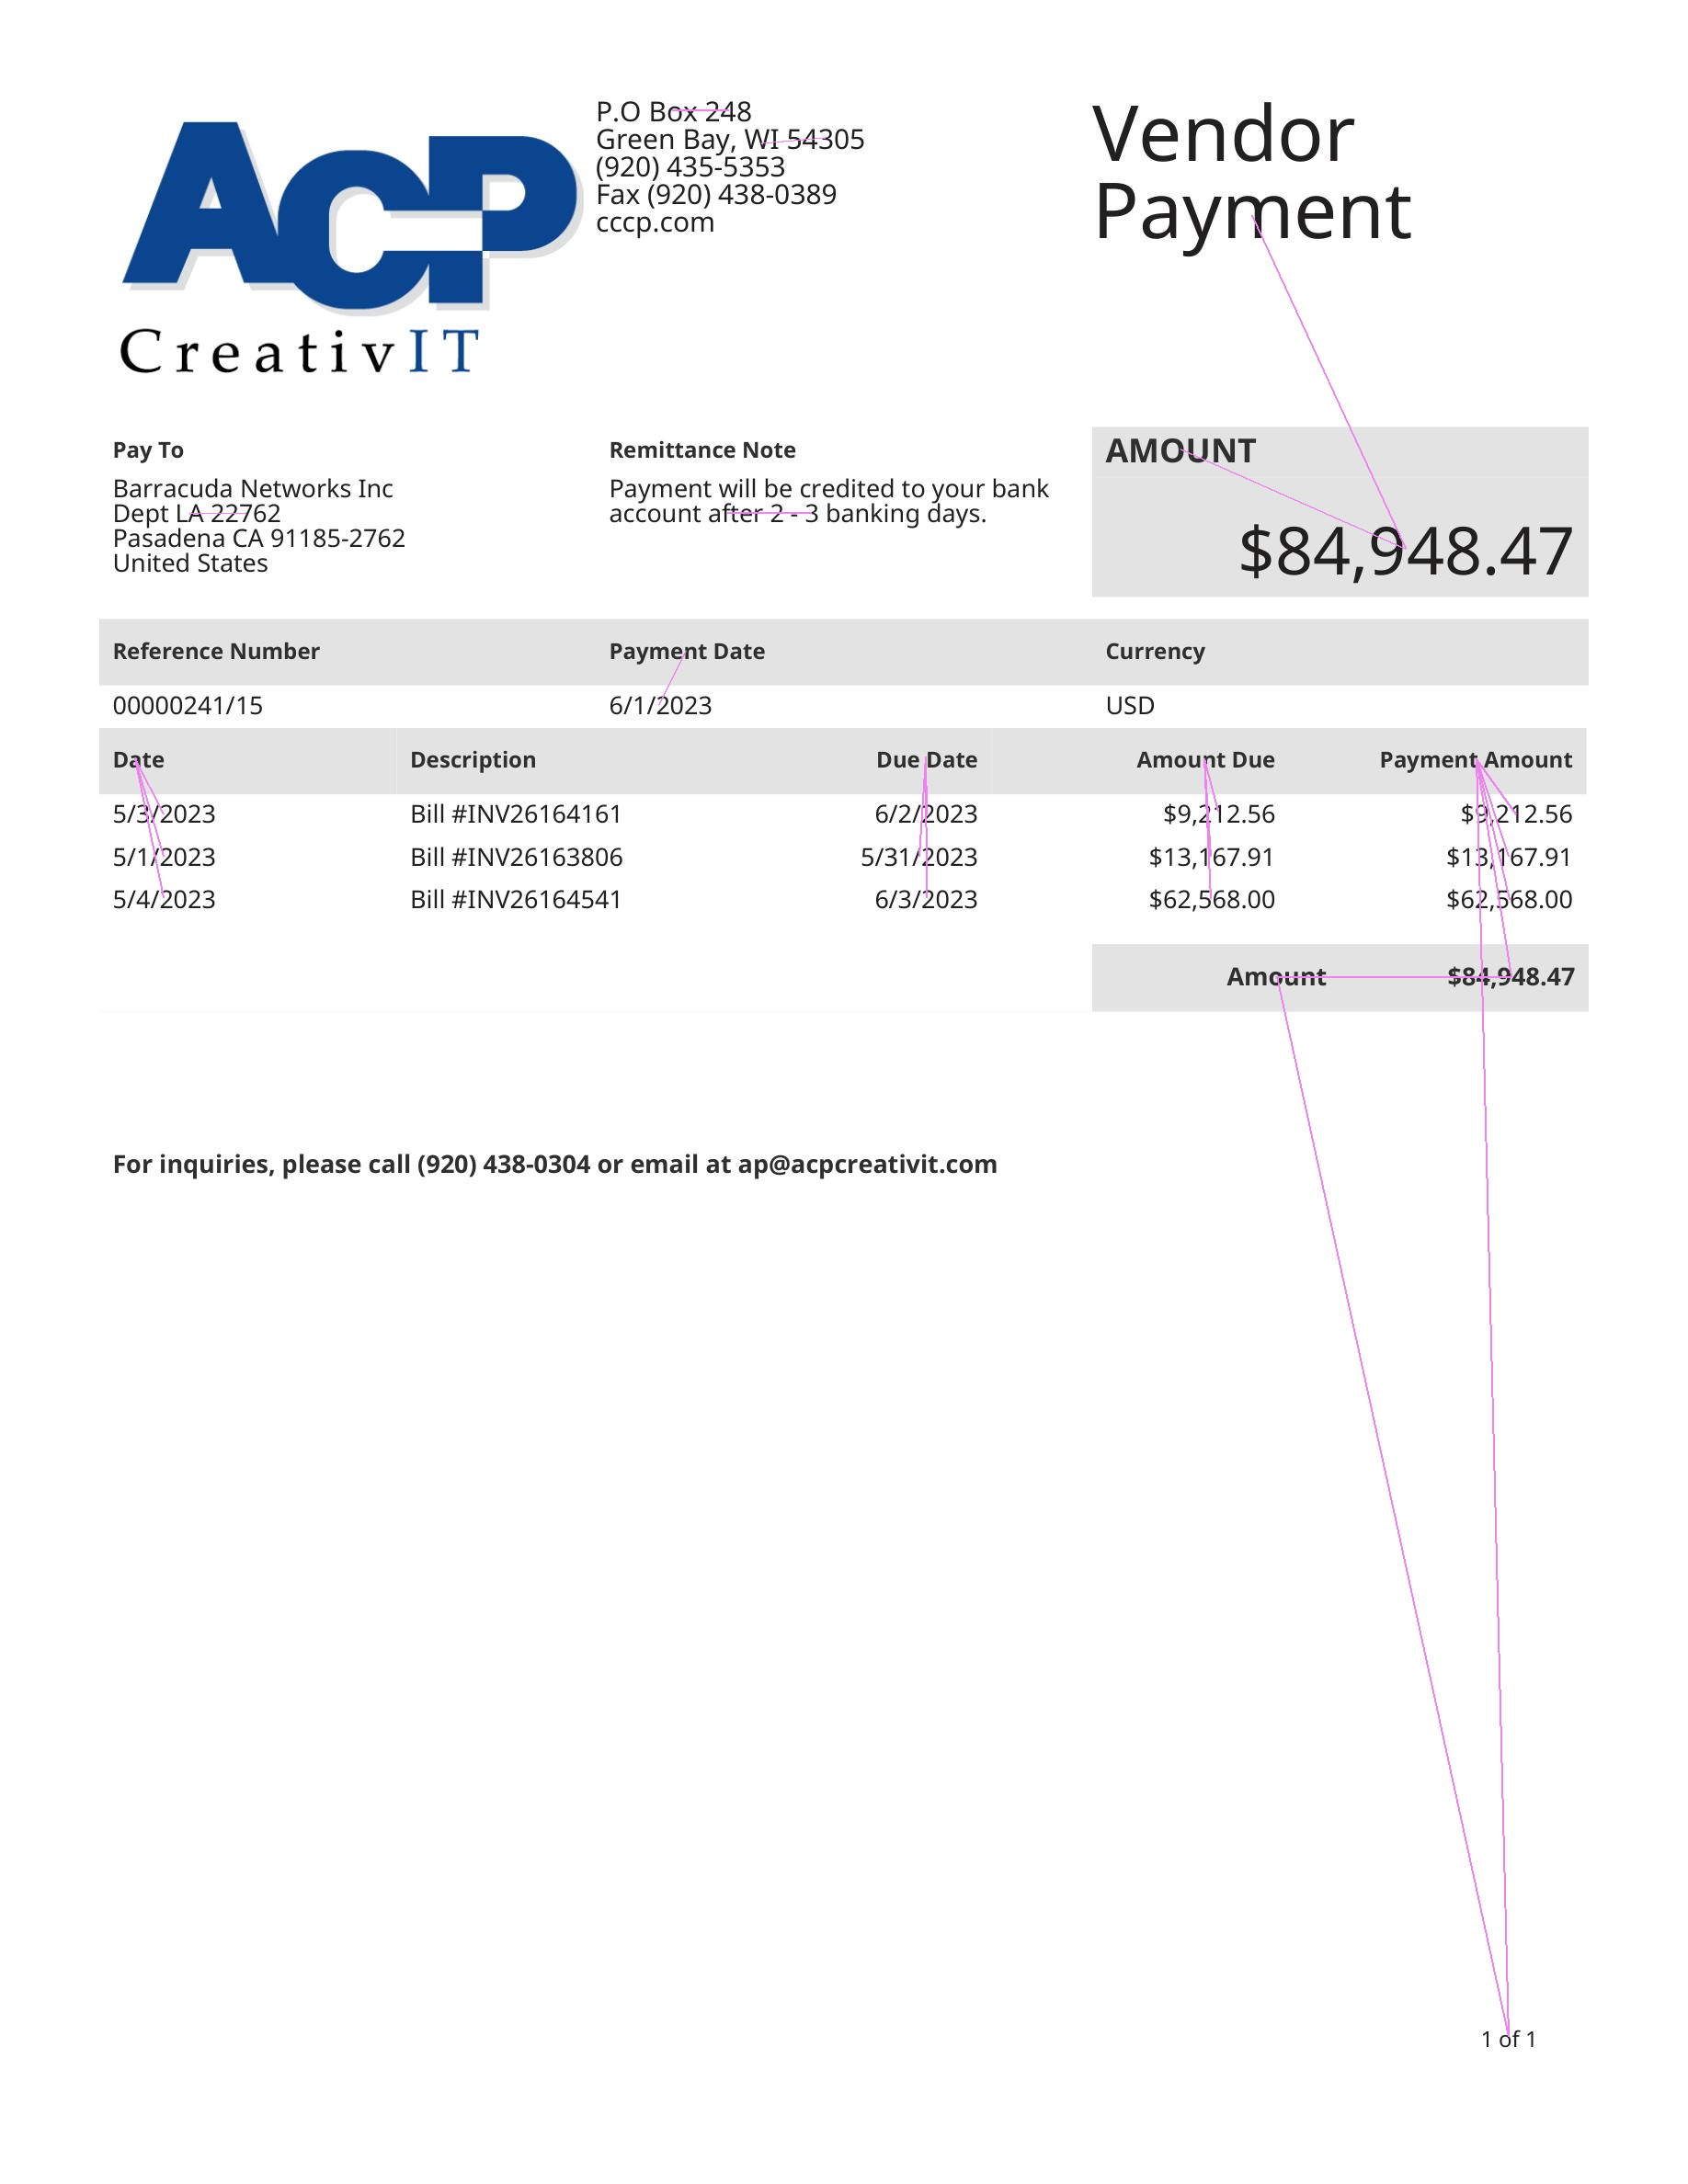

In [909]:
from src.data.preprocessing import unnormalize_box, draw_boxes


img_path = test_data.paths[idx]
img_name = os.path.basename(img_path)
        
inference = Image.open(img_path).convert('RGB')
size = inference.size

boxes = list(geom.numpy())
boxes = [unnormalize_box(box, size[0], size[1]) for box in boxes]
        
u, v = test_data.graphs[idx].edges()
links = {'src': u, 'dst': v}
        
inference = draw_boxes(inference, boxes, [], labels=None, links = links, scores=None)
inference

In [1005]:
import torch
from torch_geometric.nn import GATv2Conv

# Example input
x = torch.tensor([[0, 0, 1, 0], [0, 0, 1, 0],[0, 1, 0, 0]], dtype=torch.float)
edge_index = torch.tensor([[0, 1, 2], [1, 1, 2]], dtype=torch.int)  # Example edge indices

# Create a GATv2ConvM layer
n_heads = 1
dropout = 0
gat_layer = GATv2ConvM(4, 4, edge_dim=None, heads=n_heads, dropout=dropout, bias = False)#, aggr='add', add_self_loops=True)

# Forward pass through the GATv2ConvM layer
output = gat_layer(x, edge_index)

print("Output shape:", output.shape)


Output shape: torch.Size([3, 8])
